In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec


from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data
from tf_lab.autopredictors.plotting import plot_original_pclouds_vs_reconstructed, \
                                           plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                           plot_interpolations
from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
experiment_name = '2_virt_scan_chamfer_2fc_decoder_2048pts'
do_training = True
do_plotting = True
first_time_running = True
load_model = False

class_type = raw_input('Give me the class type.\n').lower()
class_syn_id = shape_net_category_to_synth_id()[class_type]

Give me the class type.
chair


In [4]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/2048/', class_syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/incomplete_pclouds/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/incomplete_pclouds/2_virt_scan_chamfer_2fc_decoder_2048pts'

In [5]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=20)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

6778 files containing complete point clouds were found.


In [6]:
# Make dictionary with train
train_id_file = '/orions4-zfs/projects/lins2/Panos_Space/DATA/From_Matthias/shapenet_all-train.txt'
from collections import defaultdict
train_data_dict = defaultdict(dict)
with open(train_id_file, 'r') as f_in:
    for line in f_in:
        syn_id, model_id = line.split()
        if len(train_data_dict[syn_id]) == 0:
            train_data_dict[syn_id] = set()
        train_data_dict[syn_id].add(model_id)        

In [7]:
import time

vscan_search_pattern = '.ply'
vscan_scan_pattern = '__?__.ply'
n_samples=2048

virtual_scan_data = osp.join(top_data_dir, 'From_Matthias/shapenet_dim32_sdf_pc', class_syn_id)

def _load_virtual_scan_incomplete_pcloud_temp(f_name):
    pc = Point_Cloud(ply_file=f_name)
    pc.permute_points([0, 2, 1])
    pc, _ = pc.sample(n_samples)
    pc.lex_sort()
    pc.center_in_unit_sphere()
    tokens = f_name.split('/')
    model_id = tokens[-1][:-len(vscan_scan_pattern)]
    scan_id = tokens[-1][-len(vscan_scan_pattern):-(len('.ply'))]
    class_id = tokens[-2]
    return pc.points, (model_id, scan_id), class_id



a = time.time()

noisy_pcloud_files = pio.load_filenames_of_input_data(virtual_scan_data, vscan_search_pattern)
keep = np.zeros([len(noisy_pcloud_files)], dtype=np.bool)

for i, f in enumerate(noisy_pcloud_files):    
    model_id = f.split('/')[-1][:-len(vscan_scan_pattern)]
    if model_id in train_data_dict[class_syn_id]:
        keep[i] = True

noisy_pcloud_files = np.array(noisy_pcloud_files, dtype=object)
noisy_pcloud_files = noisy_pcloud_files[keep]
noisy_pclouds, noisy_ids, class_ids = pio.load_crude_point_clouds(file_names=noisy_pcloud_files, n_threads=22,
                                                                  loader=_load_virtual_scan_incomplete_pcloud_temp)
    
print '%d files containing noisy point clouds were found.' % (len(noisy_pclouds), )

scan_ids = np.empty([len(noisy_ids)], dtype=object)
noisy_model_names = np.empty([len(noisy_ids)], dtype=object)
for i, item in enumerate(noisy_ids):
    noisy_model_names[i] = item[0]
    scan_ids[i] = item[1]

print time.time() - a

40000 files containing noisy point clouds were found.
64.359569788


In [8]:
# # Match incomplete to complete data.
mapping = match_incomplete_to_complete_data(full_model_names, noisy_model_names)
full_pclouds_matched = full_pclouds[mapping]

In [9]:
ids = noisy_model_names + '.' + scan_ids
train_data = PointCloudDataSet(full_pclouds_matched, noise=noisy_pclouds, labels=ids)

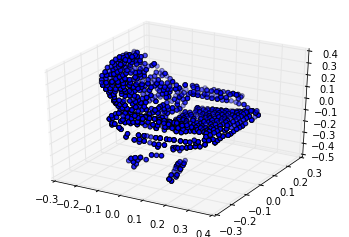

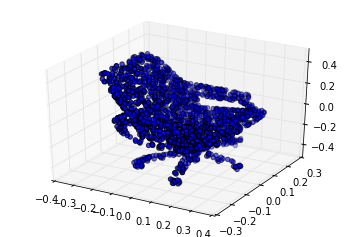

In [10]:
# TRY ME.
pp = train_data.next_batch(1)
Point_Cloud(points=pp[2].reshape(2048, 3)).plot();
Point_Cloud(points=pp[0].reshape(2048, 3)).plot();

In [12]:
if load_model:
    conf = Conf.load(osp.join(train_dir, 'configuration'))
    print conf
else:
    n_input = [2048, 3]    
    decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                    'non_linearity': tf.nn.tanh
                   }

    conf = Conf(
                n_input = n_input,
                denoising = True,
                training_epochs = 500,
                batch_size = 50,
                loss = 'chamfer',
                train_dir = train_dir,
                loss_display_step = 1,
                saver_step = 10,
                learning_rate = 0.00002,
                saver_max_to_keep = 50,
                gauss_augment = {'mu': 0, 'sigma': 0.01},
                encoder = enc_dec.encoder_with_convs_and_symmetry,
                decoder = enc_dec.decoder_with_fc_only,
                decoder_args = decoder_args,
               )

    conf.experiment_name = experiment_name
    conf.save(osp.join(conf.train_dir, 'configuration'))

In [ ]:
reset_tf_graph()
set_visible_GPUs([1,2])
ae = PointNetAutoEncoder(experiment_name, conf)

if do_training:
    ae.train(train_data, conf)

else:
    saved_epochs = read_saved_epochs(conf.train_dir)
    ae.restore_model(train_dir, saved_epochs[-1])